In [1]:
import torch
import tensorboard
print(tensorboard.__version__)
torch.cuda.is_available()


2.19.0


True

In [2]:
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import random

class RandomRotation:
    def __init__(self, amt=10.0, seed=0):
        self.generator = random.Random(seed)
        self.amt = amt

    def __call__(self, img, mask):
        angle = self.generator.uniform(-self.amt, self.amt)  # Generate a single angle
        img = TF.rotate(img, angle)  # Apply the same rotation to both
        mask = TF.rotate(mask, angle)  
        return img, mask
def color_jitter(img, hue=0.1, saturation=0.2, contrast=0.2, brightness=0.2):
    img = TF.adjust_hue(img, hue)
    return img 
def transform_fn(img, mask):
    angle = random.uniform(-10.0, 10.0)  # Generate a single angle
    
    img = TF.resize(img,[540, 540])
    img = color_jitter(img)
    img = TF.rotate(img, angle)
    img = TF.to_tensor(img)
    img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = TF.center_crop(img,[520, 520])
    
    mask = TF.resize(mask,[540, 540], interpolation=T.InterpolationMode.NEAREST)
    mask = TF.rotate(mask, angle) 
    mask = TF.pil_to_tensor(mask)
    mask = TF.center_crop(mask,[520, 520])
    return img, mask




train_dataset =VOCSegmentation(
    root='./data', year='2012', image_set='train',
    transforms=transform_fn, 
    
)
test_dataset = VOCSegmentation(
    root='./data', year='2012', image_set='val',
    transform=T.Compose([T.Resize((520, 520)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),  # No augmentation for test data
    target_transform=T.Compose([T.Resize((520, 520), interpolation=T.InterpolationMode.NEAREST), T.PILToTensor()])
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


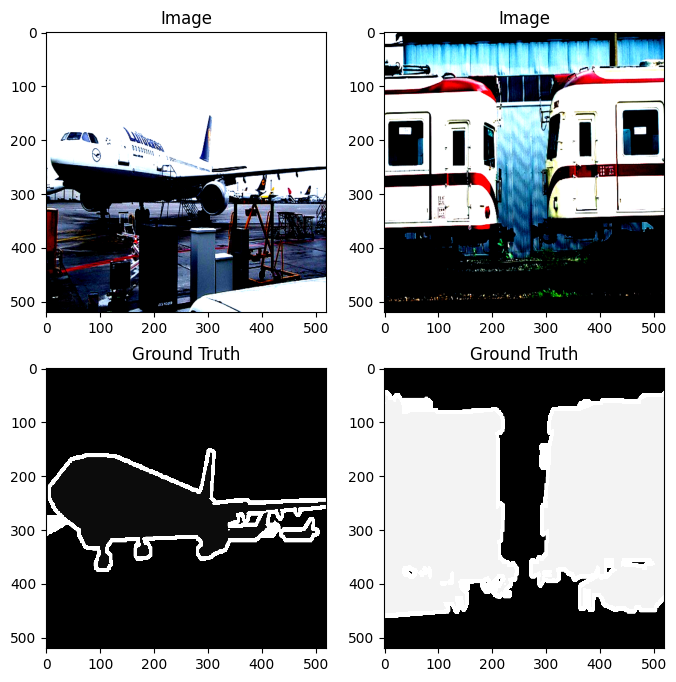

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

image,mask = next(iter(test_loader))
images_np = image.cpu().permute(0, 2, 3, 1).numpy()
masks_np = mask.squeeze(1).cpu().numpy()


fig, ax = plt.subplots(2,2,figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(images_np[i])
    ax[0, i].set_title("Image")
    ax[1, i].imshow(masks_np[i], cmap="gray", vmin=0, vmax=20)
    ax[1, i].set_title("Ground Truth")
plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, base_size = 32):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, base_size)
        self.enc2 = self.conv_block(base_size, 2*base_size)
        self.enc3 = self.conv_block(2*base_size, 4*base_size)
        self.enc4 = self.conv_block(4*base_size,8*base_size)

        # Bottleneck
        self.bottleneck = self.conv_block(8*base_size, 16*base_size)

        # Decoder (Upsampling)
        self.up4 = self.up_sample(16*base_size,8*base_size)
        self.up_conv4 = self.conv_block(16*base_size,8*base_size)
        self.up3 = self.up_sample(8*base_size,4*base_size)
        self.up_conv3 = self.conv_block(8*base_size, 4*base_size)
        self.up2 = self.up_sample(4*base_size, 2*base_size)
        self.up_conv2 = self.conv_block(4*base_size,2*base_size)
        self.up1 = self.up_sample(2*base_size,base_size)
        self.up_conv1 = self.conv_block(2*base_size, base_size)

        # Final Output Layer
        self.final_conv = nn.Conv2d(base_size, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block: 2 conv layers + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),                
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU()
        )

    def up_sample(self, in_channels, out_channels):
        """Upsampling + Convolution"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2, stride=2))
        e4 = self.enc4(F.max_pool2d(e3, kernel_size=2, stride=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2, stride=2))

        # Decoder with Skip Connections
        d4 = self.up4(b)  # upsample
        d4 = torch.cat([d4,e4],dim=1) #skip connection
        d4 = self.up_conv4(d4) #convolution
        d3 = self.up3(d4)  # upsample
        d3 = torch.cat([d3,e3],dim=1) #skip connection
        d3 = self.up_conv3(d3) #convolution
        d2 = self.up2(d3)  # upsample
        d2 = torch.cat([d2,e2],dim=1) #skip connection
        d2 = self.up_conv2(d2) #convolution
        d1 = self.up1(d2)  # upsample
        d1 = torch.cat([d1,e1],dim=1) #skip connection
        d1 = self.up_conv1(d1) #convolution

        # Final output layer
        return self.final_conv(d1)
    
    

In [5]:
from torchmetrics import JaccardIndex

class IoULoss(nn.Module):
    def __init__(self, num_classes=21, ignore_index=255):
        super(IoULoss, self).__init__()
        self.iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=ignore_index)
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim=1)
        return 1.0 - self.iou_metric(pred, target)
        

In [6]:
import torchvision.models.segmentation as models
from torch.utils.tensorboard import SummaryWriter
tbwriter = SummaryWriter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = models.fcn_resnet101().to(device)
pretrained_model.classifier[4] = nn.Conv2d(512, 21, kernel_size=1)
model = pretrained_model.to(device)
for param in model.backbone.parameters():
    param.requires_grad = False  # Freeze pretrained weights

# Loss and Optimizer
weights = torch.tensor([20.0] + [1.0] * 20).to(device) 
cel_criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=255).to(device)  # Use CrossEntropyLoss for multi-class segmentation
alpha = 1.0
n = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Training Loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_num = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Convert masks to long type
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = cel_criterion(outputs, masks.squeeze(1))
        tbwriter.add_scalar("Loss/train", loss, batch_num + len(train_loader) * epoch )
        batch_num += 1
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
    tbwriter.flush()
tbwriter.close()

Epoch 1/3, Loss: 0.3407
Epoch 2/3, Loss: 0.0850
Epoch 3/3, Loss: 0.0749


In [7]:
tbwriter.flush()
tbwriter.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


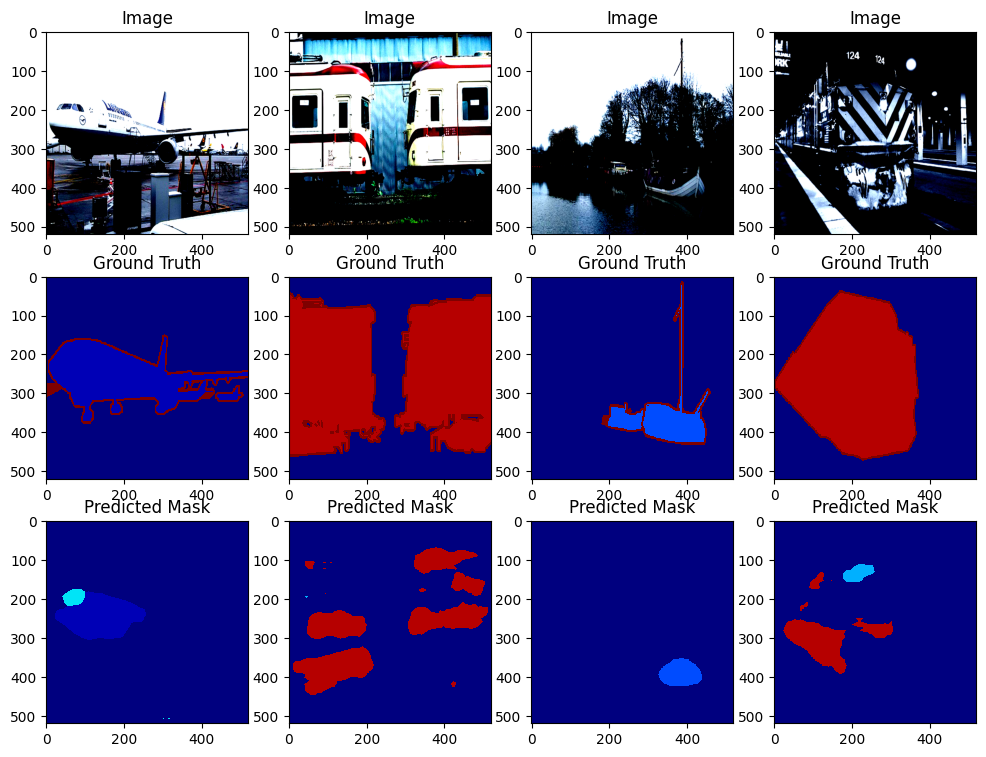

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


model.eval()
with (torch.no_grad()):
    tbwriter = SummaryWriter()
    
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device, dtype=torch.long)
    outputs = model(images)['out']
    predicted_masks = torch.argmax(outputs, dim=1)
    iou = IoULoss(ignore_index=255).to(device)
    loss = iou(outputs, masks.squeeze(1))
    tbwriter.add_scalar("IoU/test", loss, 0)
    # Convert to numpy for visualization
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    masks_np = masks.squeeze(1).cpu().numpy()
    preds_np = predicted_masks.cpu().numpy()
    # Plot sample image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):  # Show 4 samples
        axes[0, i].imshow(images_np[i])
        axes[0, i].set_title("Image")
        axes[1, i].imshow(masks_np[i], cmap="jet", vmin=0, vmax=20,interpolation="nearest")
        axes[1, i].set_title("Ground Truth")
        axes[2, i].imshow(preds_np[i], cmap="jet", vmin=0, vmax=20,interpolation="nearest")
        axes[2, i].set_title("Predicted Mask")
    tbwriter.close()
plt.show()

In [9]:
print("Unique values in mask:", torch.unique(masks))

Unique values in mask: tensor([  0,   1,   2,   4,  15,  17,  19,  20, 255], device='cuda:0')
